# Cleaning and transforming data

Files needed = ('atussum_2017.dat', 'movies.csv')

In this notebook we will continue practicing techniques for manipulating data into forms that are amenable to analysis. We will cover: 

1. `.replace()` and `unique()` for recoding variables
2. `.map()` and `.applymap()` for working element-wise on DataFrames
3. String methods for working with strings in DataFrames

We will also learn about the American Time Use Survey. 

In [1]:
import pandas as pd                 # pandas for data handling
import matplotlib.pyplot as plt     # matplotlib for plots
import numpy as np                  # numpy for numerical methods 

## American Time Use Survey (ATUS)
The Bureau of Labor Statistics oversees the [American Time Use Survey](https://www.bls.gov/tus/overview.htm), which asks a sample of Americans to complete detailed diaries keeping track of each minute of their day. 

Follow this link [www.bls.gov/tus/data/datafiles_2017.htm](https://www.bls.gov/tus/data/datafiles_2017.htm) to the page for the 2017 survey. Download the **ATUS 2017 Activity summary file (zip)** file located in the **2017 Basic ATUS Data Files** section of the page. Alternatively, download it directly [www.bls.gov/tus/datafiles/atussum_2017.zip](https://www.bls.gov/tus/datafiles/atussum_2017.zip). 

Unzip the file. We are looking for `atussum_2017.dat`. It is a comma-separated file (even though it has a '.dat' extension). Let's get it loaded.

### Variables

This data set has 421 variables! That's too many for us today. Let's just keep a few. 

The demographic variables are all uppercase letters. The time variables are of the form 'txxyyzz' where xx is the major category code, yy is the second-tier code, and zz is the third-tier code. ([docs](https://www.bls.gov/tus/lexicons/lexiconwex2017.pdf))

Let's keep some demographic data and some data about working and sleeping. 

In [2]:
variables = {'TEAGE':'age', 'TESEX':'sex', 'PTDTRACE':'race', 'PEEDUCA':'edu', 'GTMETSTA':'metro', 'TELFS':'employ', 
 'TUDIARYDAY':'day', 't050101':'work_main', 't050102':'work_other', 't010101':'sleep', 't050201':'work_soc', 't010102':'no_sleep'}

In [3]:
atus_small = pd.read_csv('atussum_2017.dat', usecols=variables.keys())

In [4]:
atus_small.rename(columns=variables, inplace=True)

In [5]:
atus_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10223 entries, 0 to 10222
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   age         10223 non-null  int64
 1   sex         10223 non-null  int64
 2   edu         10223 non-null  int64
 3   race        10223 non-null  int64
 4   metro       10223 non-null  int64
 5   employ      10223 non-null  int64
 6   day         10223 non-null  int64
 7   sleep       10223 non-null  int64
 8   no_sleep    10223 non-null  int64
 9   work_main   10223 non-null  int64
 10  work_other  10223 non-null  int64
 11  work_soc    10223 non-null  int64
dtypes: int64(12)
memory usage: 958.5 KB


Okay, let's start transforming the data to get it ready for analysis. 

### A word on loops
We have seen many places where a loop saved us time and effort. It might seem natural to use a loop to perform an operation on each element of a column or a DataFrame. 

In general, however, we want to avoid this. Instead, we have used pandas vectorized operations such as 
```python
x['new_var'] = x['var_1'] / x['var_2']
```
to perform element-wise division. Using pandas' native operations is much (much much) faster than looping over the rows of a DataFrame. A lot of optimization has been written into the native functions that is not there when we loop ourselves. If you find yourself looping over the rows of a DataFrame, take a step back and think about other ways forward. 

Fortunately, pandas provides methods that let us do very complex and very general operations to a DataFrame without resorting to a loop. We consider a few of these below. 

### replace( ) 

The sex variable is coded 1 for male and 2 for female. I do not want to have to remember that!

The `replace( )` method replaces one value for another. One syntax is 
```
atus_small['sex'] = atus_small['sex'].replace(1, 'male')
```
but a more powerful one passes a dict or a list.
```
atus_small['sex'] = atus_small['sex'].replace({1:'male', 2:'female'})
```

In [6]:
sex_codes = {1:'male', 2:'female'}
atus_small['sex'] = atus_small['sex'].replace(sex_codes)
atus_small.head()

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
0,34,female,39,2,1,1,1,728,0,450,0,0
1,28,female,40,1,1,5,7,385,0,0,0,0
2,15,male,35,3,1,5,4,570,0,0,0,0
3,46,male,39,1,1,1,2,525,0,480,0,0
4,85,male,44,1,1,1,7,756,0,0,0,0


### unique( )
Let's code race, too. What codes are in our data? The method `unique( )` returns the unique values.

In [7]:
races = atus_small['race'].unique()
races.sort()
print(races)

[ 1  2  3  4  5  6  7  8  9 10 11 13 16 18]


In [8]:
# I looked up the codes in the documentation...

race_codes = {1:'white', 2:'black', 3:'native_am', 4:'asian', 5:'hawaiian', 6:'wh_bl', 
              7:'wh_na', 8:'wh_as', 9:'wh_ha', 10:'bl_na', 11:'bl_as', 13:'na_as', 16:'wh_bl_as', 18:'wh_as_ha'}

In [9]:
atus_small['race'] = atus_small['race'].replace(race_codes)

In [10]:
atus_small.head()

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
0,34,female,39,black,1,1,1,728,0,450,0,0
1,28,female,40,white,1,5,7,385,0,0,0,0
2,15,male,35,native_am,1,5,4,570,0,0,0,0
3,46,male,39,white,1,1,2,525,0,480,0,0
4,85,male,44,white,1,1,7,756,0,0,0,0


### Apply a function to a Series \[a single column\]: map( )

We can apply functions to the individual elements in a column, too. The `map()` functions handles this for us. It applies the given function to each element of the column. These can be built-in functions, or user-defined functions. This is quite powerful. We can write a function that performs a complicated transformation and apply to each element of a column in one simple line.  

Let's define a function that converts minutes to hours. 

In [11]:
def minutes_to_hours(x):
    return x/60

Now apply `map( )` to the work column. 

\[This example is a bit contrived. We could have just as easily done `atus_small['work_main']/60`. But that wouldn't have given us practice with `map( )`.\] 

In [12]:
atus_small['work_main'] = atus_small['work_main'].map(minutes_to_hours)
atus_small.head()

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
0,34,female,39,black,1,1,1,728,0,7.5,0,0
1,28,female,40,white,1,5,7,385,0,0.0,0,0
2,15,male,35,native_am,1,5,4,570,0,0.0,0,0
3,46,male,39,white,1,1,2,525,0,8.0,0,0
4,85,male,44,white,1,1,7,756,0,0.0,0,0


### Apply a function to a DataFrame: applymap( )
If we want to apply the same function to each element in several columns of a DataFrame (rather than a Series) we can use `applymap( )`. It works the same way, applying the function to each element. 

\[Note: Depending on which version of Anaconda you're working in, you may get an error indicating that `applymap()` is being deprecated and you should use `map()` instead. This is a recent change. I have always wondered why the developers of pandas created separate methods for a Series vs. a DataFrame. Well, they recently decided to remove confusion. If you get an error below (even if the code runs), you can change `applymap()` to `map()`. Alternatively, you can use `apply()` on both Series and DataFrame objects. \]

In [13]:
# We can map to several columns at once.
atus_small[['work_other', 'sleep', 'no_sleep']] = atus_small[['work_other', 'sleep', 'no_sleep']].apply(minutes_to_hours)
atus_small.head()

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
0,34,female,39,black,1,1,1,12.133333,0.0,7.5,0.0,0
1,28,female,40,white,1,5,7,6.416667,0.0,0.0,0.0,0
2,15,male,35,native_am,1,5,4,9.500000,0.0,0.0,0.0,0
3,46,male,39,white,1,1,2,8.750000,0.0,8.0,0.0,0
4,85,male,44,white,1,1,7,12.600000,0.0,0.0,0.0,0


`.map()` and `.applymap()` are very powerful methods. They can do a lot more than we have covered and they can be used to do very complex manipulations. We won't need those advanced capabilities, but they are out there if you someday do.   

## Top Hat Practice Exercise: Transform
Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. 

1. `edu` in 'atus_small' holds the highest level of education obtained. It can take values between 31 and 46. Covert the numeric values to labels. 

   * 39 = 'high school'
   * 40 = 'some college'
   * 41 & 42 are 'associate'
   * 43 = 'bachelor'
   * 44 = 'master'
   * 45 = 'prof'
   * 46 = 'phd'

In [14]:
educ_codes = {39:'high school', 40:'some college', 41:'associate', 42:'associate', 
              43: 'bachelor', 44: 'master', 45:'prof', 46:'phd'}

atus_small['edu'] = atus_small['edu'].replace(educ_codes)
atus_small.sample(10)

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
2250,70,female,high school,white,1,5,5,9.500000,0.0,0.000000,0.0,0
1901,60,male,high school,white,3,1,7,10.000000,0.0,0.000000,0.0,0
4412,51,male,high school,white,2,1,6,7.000000,0.0,0.250000,0.0,0
10168,80,male,33,white,1,5,4,9.500000,1.0,0.000000,0.0,0
6159,50,male,associate,white,1,1,2,7.916667,0.0,10.333333,0.0,0
7091,66,female,bachelor,black,1,1,7,6.000000,0.0,0.000000,0.0,0
1737,45,male,some college,white,1,5,3,8.000000,0.0,0.000000,0.0,0
5746,69,male,high school,white,1,5,6,8.750000,0.0,0.000000,0.0,0
8050,45,male,bachelor,white,1,1,1,8.750000,0.0,0.000000,0.0,0
9135,57,male,some college,white,1,1,4,7.500000,0.0,9.666667,0.0,0


In [15]:
# Another way to do it is to write a function like this

def recode(x):
    educ_codes = {39:'high school', 40:'some college', 41:'associate', 42:'associate', 
              43: 'bachelor', 44: 'master', 45:'prof', 46:'phd'}
    return educ_codes[x]
    
# and use .map() 
# atus_small['edu'] = atus_small['edu'].map(recode)

2. Print out a list of the unique values in the column 'edu'. 

In [16]:
atus_small['edu'].unique()

array(['high school', 'some college', 35, 'master', 'bachelor', 36,
       'prof', 'associate', 'phd', 37, 34, 33, 38, 31, 32], dtype=object)

3. Apply the `minutes_to_hours` function to the `work_soc` variable. This variable is the time spent 'Socializing, relaxing, and leisure as part of job'. I have no idea what kind of jobs makes you relax and take leisure. 

In [17]:
atus_small['work_soc'] = atus_small['work_soc'].map(minutes_to_hours)
atus_small.head()

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc
0,34,female,high school,black,1,1,1,12.133333,0.0,7.5,0.0,0.0
1,28,female,some college,white,1,5,7,6.416667,0.0,0.0,0.0,0.0
2,15,male,35,native_am,1,5,4,9.500000,0.0,0.0,0.0,0.0
3,46,male,high school,white,1,1,2,8.750000,0.0,8.0,0.0,0.0
4,85,male,master,white,1,1,7,12.600000,0.0,0.0,0.0,0.0


4. Create a column named 'work' that is the sum of 'work_main' and 'work_other'.

In [18]:
atus_small['work'] = atus_small['work_main'] + atus_small['work_other']

In [19]:
atus_small.sample(10)

,age,sex,edu,race,metro,employ,day,sleep,no_sleep,work_main,work_other,work_soc,work
5789,37,female,master,asian,1,1,5,7.500000,0.0,11.5,0.00,0.0,11.50
1559,67,male,master,white,1,1,1,10.000000,0.0,0.0,0.00,0.0,0.00
10110,53,male,high school,white,1,5,4,15.833333,0.0,0.0,0.00,0.0,0.00
277,45,male,bachelor,white,1,1,1,5.000000,0.0,1.0,8.75,0.0,9.75
5855,37,male,high school,white,2,5,1,8.666667,0.0,0.0,0.00,0.0,0.00
2348,23,female,bachelor,white,1,5,4,5.833333,0.0,0.0,0.00,0.0,0.00
4953,29,female,35,white,2,5,4,6.500000,0.0,0.0,0.00,0.0,0.00
6113,42,male,some college,white,2,1,1,6.000000,0.0,7.0,0.00,0.0,7.00
1872,35,male,high school,white,1,1,7,9.733333,0.0,0.0,0.00,0.0,0.00
7342,71,male,high school,native_am,2,5,7,5.500000,0.0,0.0,0.00,0.0,0.00


5. Create a histogram of 'work' for only those observations with work>0. 

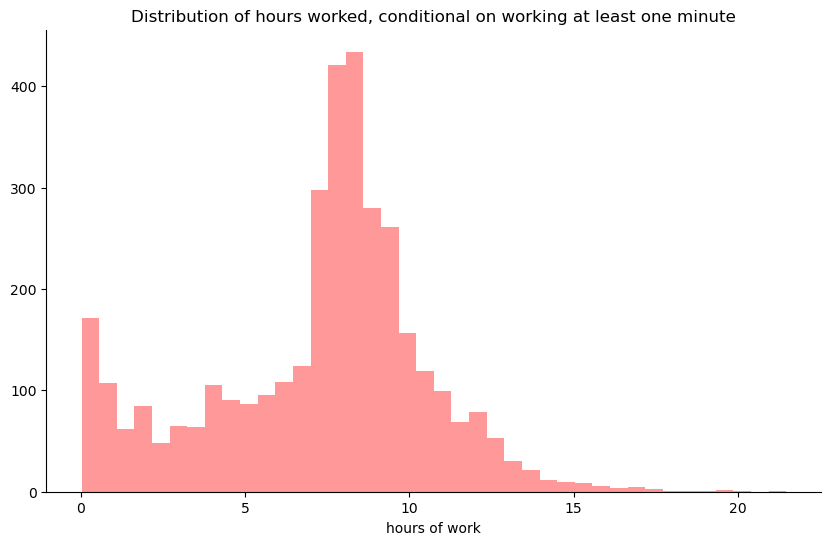

In [20]:
fig, ax = plt.subplots(figsize=(10,6))


ax.hist(atus_small.loc[ atus_small['work']>0, 'work'], bins=40, alpha = 0.4, color = 'red')

ax.set_xlabel('hours of work')
ax.set_title('Distribution of hours worked, conditional on working at least one minute')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Extra practice
If you finish early, try rewriting your solution to part 1, but code values less than 39 as "less than high school".

## String methods
We have seen some of these before, when we learned about strings. These are analogous to the string methods in standard python, but they have been optimized for DataFrames. These *vectorized string methods*, work element-wise over an entire column. The method call looks like

```python
data['var'].str.method()
```

where `.str.method( )` is the method we are applying. A list of vectorized string methods is on page 218 in McKinney and in the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#method-summary). Below, we try a few out. 

### MovieLens data set

We are going to work with the [MovieLens](https://grouplens.org/datasets/movielens/) *ml-latest-small* dataset. The GroupLens organization released this data. It is meant to help build recommendation algorithms, like the ones you see in Netflix or Spotify. \[In 2006, [Netflix started a contest](https://en.wikipedia.org/wiki/Netflix_Prize), with a $1 mil. reward, for an algorithm that could beat their own.\] They have other ratings datasets, too, on music, jokes, and books.  

An observation is a movie.

In [21]:
movies = pd.read_csv('movies.csv')
movies.sample(10)

,movieId,title,genres
6107,42723,Hostel (2005),Horror
7900,95135,Your Sister's Sister (2011),Comedy|Drama
3601,4945,"Enforcer, The (1976)",Crime
2138,2846,"Adventures of Milo and Otis, The (Koneko monog...",Adventure|Children|Comedy|Drama
299,341,Double Happiness (1994),Drama
4942,7449,Godsend (2004),Drama|Horror|Thriller
2500,3341,Born Yesterday (1950),Comedy
6294,47999,Jesus Camp (2006),Documentary|Drama
6219,45672,Click (2006),Adventure|Comedy|Drama|Fantasy|Romance
4316,6305,Fahrenheit 451 (1966),Drama|Sci-Fi


### str.contains( )
The genres are mixed together. Let's get all the comedies. The `.contains( )` method returns a bool Series with True for observations in which the string contains the search term.

In [22]:
movies['genres'].str.contains('Comedy')

0        True
1       False
2        True
3        True
4        True
        ...  
9737     True
9738     True
9739    False
9740    False
9741     True
Name: genres, Length: 9742, dtype: bool

In [23]:
print(movies.shape)
comedies = movies[movies['genres'].str.contains('Comedy')]
print(comedies.shape)

(9742, 3)
(3756, 3)


### str.split( )
This method splits the string up at the delimiter that is passed to `.split( )`. It returns a list of each chunk that falls between the delimiter. 

This could be useful processing data that come in the form: last,first or city,state. 

In [24]:
# The movie genres are separated with the '|' character. 
# Remember, DataFrames can have columns of lists...

movies['genre_split'] = movies['genres'].str.split('|')
movies.head()

,movieId,title,genres,genre_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [25]:
movies.loc[0,'genre_split']

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']

### str.join ( )
Put strings together. Separate the pieces with a delimiter of your choosing. 

In [26]:
movies['with_colons'] = movies['genre_split'].str.join('::')
movies.sample(5)

,movieId,title,genres,genre_split,with_colons
862,1135,Private Benjamin (1980),Comedy,[Comedy],Comedy
5903,33639,Mad Hot Ballroom (2005),Children|Documentary,"[Children, Documentary]",Children::Documentary
2067,2746,Little Shop of Horrors (1986),Comedy|Horror|Musical,"[Comedy, Horror, Musical]",Comedy::Horror::Musical
7851,93723,Damsels in Distress (2011),Comedy|Romance,"[Comedy, Romance]",Comedy::Romance
7716,90376,We Need to Talk About Kevin (2011),Drama|Thriller,"[Drama, Thriller]",Drama::Thriller


## Top Hat Practice Exercise: String Transforms

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. I am here, too. 

Our data does not have a column for the year the movie was released. Let's create one. The year the movie was released is in the title string.    

0. Reload 'movies.csv'
1. Use `.str.strip()` ([docs](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.Series.str.strip.html)) to remove any leading or trailing spaces from 'title'.

1. Extract the four-digit year from the titles and put them into a new column named 'year'.  

Notice that the year, including the parentheses, is always the last 6 digits of the title. You might try `str.slice()` and work with negative indexes to count from the end of 'title'. 

If there is any extra space at the end of a title, it will mess up my algorithm! That's why we strip the extra spaces first. 

In [27]:
# The negative notation counts backwards. I am relying on the fact that each title ends in '(year)'. 
# Not the most robust method.
movies = pd.read_csv('movies.csv')

movies['title'] = movies['title'].str.strip()
movies['year'] = movies['title'].str.slice(-5, -1)
movies.head(2)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995


3. There are 12 movies that do not have a year in their title. Find them in your DataFrame. You might try the `str.isdigit()` [(doc)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.isdigit.html#pandas.Series.str.isdigit) method to see if the year you extracted in step 2. is numeric. 

In [28]:
movies.loc[~movies['year'].str.isdigit()]

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,lon
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,r On
9091,143410,Hyena Road,(no genres listed),Roa
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),atso
9179,149334,Nocturnal Animals,Drama|Thriller,imal
9259,156605,Paterson,(no genres listed),erso
9367,162414,Moonlight,Drama,ligh
9448,167570,The OA,(no genres listed),he O
9514,171495,Cosmos,(no genres listed),osmo
9515,171631,Maria Bamford: Old Baby,(no genres listed),Bab


4. For the movies without a year, set the 'year' variable to `np.nan`. Use `.unique()` to check that all the 'year' values are either numbers (as strings) or `nan`.

`np.nan` is the "not a number" object. Pandas will interpret that it as a missing value. 

In [29]:
movies.loc[~movies['year'].str.isdigit(), 'year'] = np.nan
movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908'], dtype=object)

5. Convert the year variable to datetime. Check your dtypes to verify. 

In [30]:
movies['year'] = pd.to_datetime(movies['year'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   movieId  9742 non-null   int64         
 1   title    9742 non-null   object        
 2   genres   9742 non-null   object        
 3   year     9730 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 304.6+ KB


## Bonus practice to try at home

If you finished early, compute the number of movies in the DataFrame for each year. You might try `.groupby()`.

1. Which year has the most observations?

In [31]:
movie_counts = movies[['year', 'movieId']].groupby('year').count()
most = movie_counts['movieId'].sort_values().tail(1).index.date[0].year
f'The year {most} has the most movies in the dataset.'

'The year 2002 has the most movies in the dataset.'

Here is something I have not figured out yet...

2. How many movies are there in each decade? i.e., 1900&ndash;1909, 1910&ndash;1919, 1920&ndash;1929...

In [32]:
# I tried this, but I want the first bin to be 1900-01-01...
movie_counts.resample('10AS').sum()

# I know that I can use pd.cut(), but I think there is some way to get this to work by just resampling. 
# If you figure it out, let me know!

,movieId
year,
1902-01-01,3
1912-01-01,10
1922-01-01,53
1932-01-01,160
1942-01-01,197
1952-01-01,307
1962-01-01,410
1972-01-01,601
1982-01-01,1290
